In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import ops
from keras import layers

from glob import glob

ImportError: DLL load failed while importing _c_internal_utils: The specified module could not be found.

In [2]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/c6/c8/6936e8c7b279a5abac82f399d8d72ac25da530cf5f78a0e40063e492558c/matplotlib-3.9.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/d6/4f/76d0dd0bca417691918484c26c74dd9dd44fbf528bbfeb30d754886e2c54/contourpy-1.2.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/00/48/8e9ca9e17de09f5a18d9afb3a3f456689491b985bd144ccc1d9b0c3c06bf/fonttools-4.53.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/165.5 kB ? eta

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
PATH = r"./facades_data/"
SPLIT = 0.2

files = glob(PATH + "*.jpg")
np.random.shuffle(files)

split_index = int(len(files) * (1 - SPLIT))
train_files = files[:split_index]
val_files = files[split_index:]

print(f"Total samples: {len(files)}.")
print(f"Total training samples: {len(train_files)}.")
print(f"Total validation samples: {len(val_files)}.")

Total samples: 378.
Total training samples: 302.
Total validation samples: 76.


In [2]:
BATCH_SIZE = 4
IMG_HEIGHT = IMG_WIDTH = 256
NUM_CLASSES = 12
AUTOTUNE = tf.data.AUTOTUNE


def load(image_files, batch_size, is_train=True):
    def _random_crop(
        segmentation_map,
        image,
        labels,
        crop_size=(IMG_HEIGHT, IMG_WIDTH),
    ):
        crop_size = tf.convert_to_tensor(crop_size)
        image_shape = tf.shape(image)[:2]
        margins = image_shape - crop_size
        y1 = tf.random.uniform(shape=(), maxval=margins[0], dtype=tf.int32)
        x1 = tf.random.uniform(shape=(), maxval=margins[1], dtype=tf.int32)
        y2 = y1 + crop_size[0]
        x2 = x1 + crop_size[1]

        cropped_images = []
        images = [segmentation_map, image, labels]
        for img in images:
            cropped_images.append(img[y1:y2, x1:x2])
        return cropped_images

    def _load_data_tf(image_file, segmentation_map_file, label_file):
        image = tf.image.decode_png(tf.io.read_file(image_file), channels=3)
        segmentation_map = tf.image.decode_png(
            tf.io.read_file(segmentation_map_file), channels=3
        )
        labels = tf.image.decode_bmp(tf.io.read_file(label_file), channels=0)
        labels = tf.squeeze(labels)

        image = tf.cast(image, tf.float32) / 127.5 - 1
        segmentation_map = tf.cast(segmentation_map, tf.float32) / 127.5 - 1
        return segmentation_map, image, labels

    def _one_hot(segmentation_maps, real_images, labels):
        labels = tf.one_hot(labels, NUM_CLASSES)
        labels.set_shape((None, None, NUM_CLASSES))
        return segmentation_maps, real_images, labels

    segmentation_map_files = [
        image_file.replace("images", "segmentation_map").replace("jpg", "png")
        for image_file in image_files
    ]
    label_files = [
        image_file.replace("images", "segmentation_labels").replace("jpg", "bmp")
        for image_file in image_files
    ]
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_files, segmentation_map_files, label_files)
    )

    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    dataset = dataset.map(_load_data_tf, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(_random_crop, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(_one_hot, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


train_dataset = load(train_files, batch_size=BATCH_SIZE, is_train=True)
val_dataset = load(val_files, batch_size=BATCH_SIZE, is_train=False)

NameError: name 'tf' is not defined

Segmentation map batch shape: (4, 256, 256, 3).
Image batch shape: (4, 256, 256, 3).
One-hot encoded label map shape: (4, 256, 256, 12).


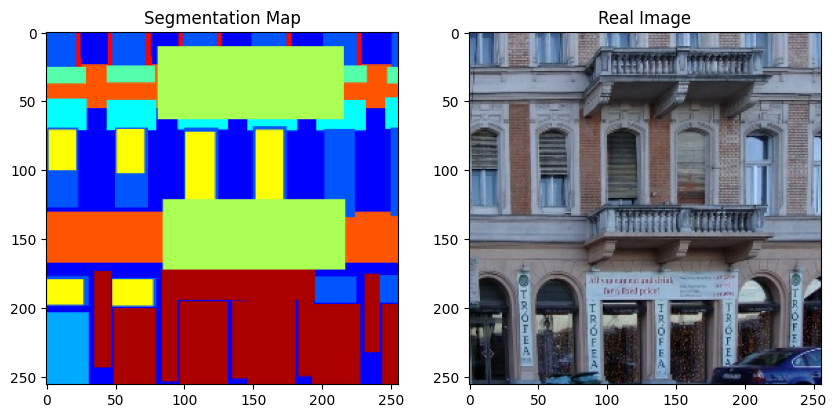

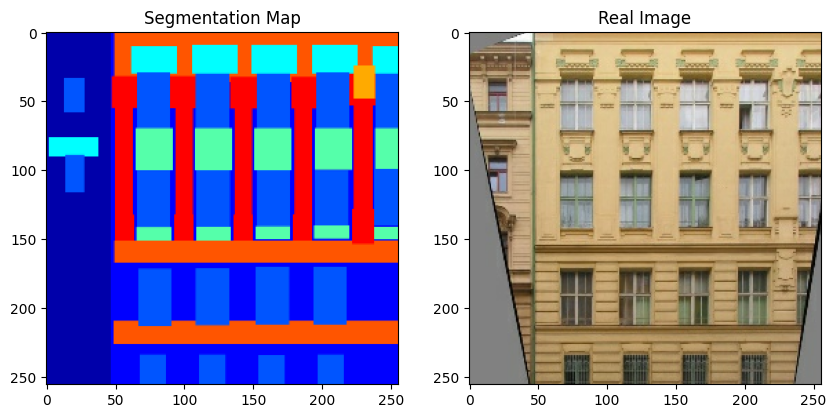

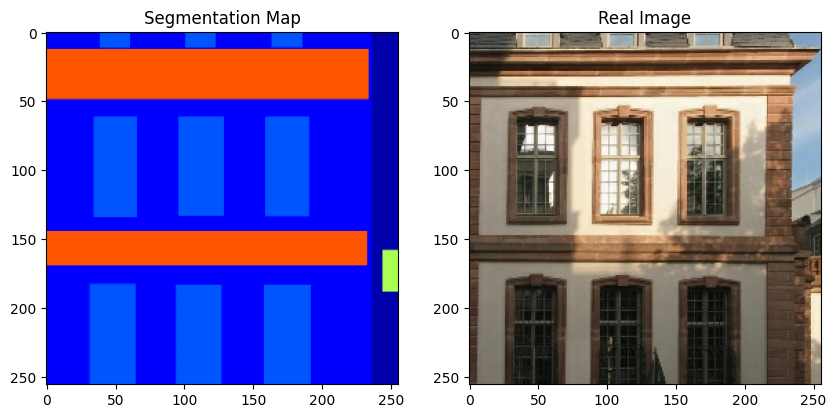

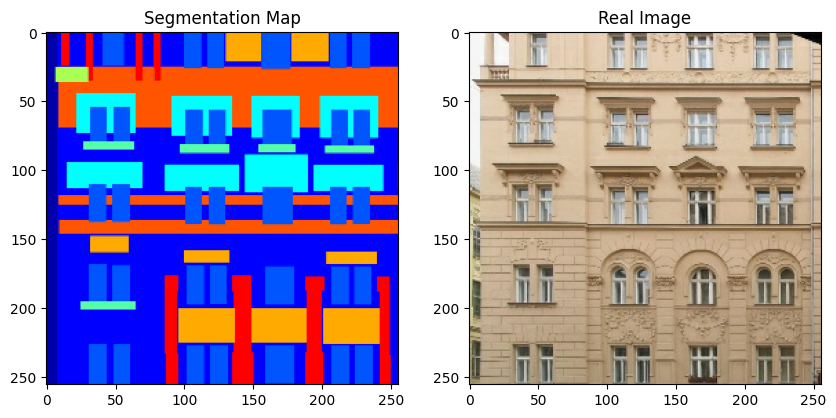

In [9]:
sample_train_batch = next(iter(train_dataset))
print(f"Segmentation map batch shape: {sample_train_batch[0].shape}.")
print(f"Image batch shape: {sample_train_batch[1].shape}.")
print(f"One-hot encoded label map shape: {sample_train_batch[2].shape}.")

# Plot a view samples from the training set.
for segmentation_map, real_image in zip(sample_train_batch[0], sample_train_batch[1]):
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1).set_title("Segmentation Map")
    plt.imshow((segmentation_map + 1) / 2)
    fig.add_subplot(1, 2, 2).set_title("Real Image")
    plt.imshow((real_image + 1) / 2)
    plt.show()

In [10]:

class SPADE(layers.Layer):
    def __init__(self, filters, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.conv = layers.Conv2D(128, 3, padding="same", activation="relu")
        self.conv_gamma = layers.Conv2D(filters, 3, padding="same")
        self.conv_beta = layers.Conv2D(filters, 3, padding="same")

    def build(self, input_shape):
        self.resize_shape = input_shape[1:3]

    def call(self, input_tensor, raw_mask):
        mask = ops.image.resize(raw_mask, self.resize_shape, interpolation="nearest")
        x = self.conv(mask)
        gamma = self.conv_gamma(x)
        beta = self.conv_beta(x)
        mean, var = ops.moments(input_tensor, axes=(0, 1, 2), keepdims=True)
        std = ops.sqrt(var + self.epsilon)
        normalized = (input_tensor - mean) / std
        output = gamma * normalized + beta
        return output


class ResBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.spade_1 = SPADE(input_filter)
        self.spade_2 = SPADE(self.filters)
        self.conv_1 = layers.Conv2D(self.filters, 3, padding="same")
        self.conv_2 = layers.Conv2D(self.filters, 3, padding="same")
        self.learned_skip = False

        if self.filters != input_filter:
            self.learned_skip = True
            self.spade_3 = SPADE(input_filter)
            self.conv_3 = layers.Conv2D(self.filters, 3, padding="same")

    def call(self, input_tensor, mask):
        x = self.spade_1(input_tensor, mask)
        x = self.conv_1(keras.activations.leaky_relu(x, 0.2))
        x = self.spade_2(x, mask)
        x = self.conv_2(keras.activations.leaky_relu(x, 0.2))
        skip = (
            self.conv_3(
                keras.activations.leaky_relu(self.spade_3(input_tensor, mask), 0.2)
            )
            if self.learned_skip
            else input_tensor
        )
        output = skip + x
        return output


class GaussianSampler(layers.Layer):
    def __init__(self, batch_size, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        means, variance = inputs
        epsilon = keras.random.normal(
            shape=(self.batch_size, self.latent_dim),
            mean=0.0,
            stddev=1.0,
            seed=self.seed_generator,
        )
        samples = means + ops.exp(0.5 * variance) * epsilon
        return samples


In [11]:

def downsample(
    channels,
    kernels,
    strides=2,
    apply_norm=True,
    apply_activation=True,
    apply_dropout=False,
):
    block = keras.Sequential()
    block.add(
        layers.Conv2D(
            channels,
            kernels,
            strides=strides,
            padding="same",
            use_bias=False,
            kernel_initializer=keras.initializers.GlorotNormal(),
        )
    )
    if apply_norm:
        block.add(layers.GroupNormalization(groups=-1))
    if apply_activation:
        block.add(layers.LeakyReLU(0.2))
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    return block


In [12]:

def build_encoder(image_shape, encoder_downsample_factor=64, latent_dim=256):
    input_image = keras.Input(shape=image_shape)
    x = downsample(encoder_downsample_factor, 3, apply_norm=False)(input_image)
    x = downsample(2 * encoder_downsample_factor, 3)(x)
    x = downsample(4 * encoder_downsample_factor, 3)(x)
    x = downsample(8 * encoder_downsample_factor, 3)(x)
    x = downsample(8 * encoder_downsample_factor, 3)(x)
    x = layers.Flatten()(x)
    mean = layers.Dense(latent_dim, name="mean")(x)
    variance = layers.Dense(latent_dim, name="variance")(x)
    return keras.Model(input_image, [mean, variance], name="encoder")


In [13]:

def build_generator(mask_shape, latent_dim=256):
    latent = keras.Input(shape=(latent_dim,))
    mask = keras.Input(shape=mask_shape)
    x = layers.Dense(16384)(latent)
    x = layers.Reshape((4, 4, 1024))(x)
    x = ResBlock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=1024)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=512)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=256)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = ResBlock(filters=128)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)
    x = keras.activations.leaky_relu(x, 0.2)
    output_image = keras.activations.tanh(layers.Conv2D(3, 4, padding="same")(x))
    return keras.Model([latent, mask], output_image, name="generator")


In [14]:

def build_discriminator(image_shape, downsample_factor=64):
    input_image_A = keras.Input(shape=image_shape, name="discriminator_image_A")
    input_image_B = keras.Input(shape=image_shape, name="discriminator_image_B")
    x = layers.Concatenate()([input_image_A, input_image_B])
    x1 = downsample(downsample_factor, 4, apply_norm=False)(x)
    x2 = downsample(2 * downsample_factor, 4)(x1)
    x3 = downsample(4 * downsample_factor, 4)(x2)
    x4 = downsample(8 * downsample_factor, 4, strides=1)(x3)
    x5 = layers.Conv2D(1, 4)(x4)
    outputs = [x1, x2, x3, x4, x5]
    return keras.Model([input_image_A, input_image_B], outputs)


In [15]:

def generator_loss(y):
    return -ops.mean(y)


def kl_divergence_loss(mean, variance):
    return -0.5 * ops.sum(1 + variance - ops.square(mean) - ops.exp(variance))


class FeatureMatchingLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mae = keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        loss = 0
        for i in range(len(y_true) - 1):
            loss += self.mae(y_true[i], y_pred[i])
        return loss


class VGGFeatureMatchingLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder_layers = [
            "block1_conv1",
            "block2_conv1",
            "block3_conv1",
            "block4_conv1",
            "block5_conv1",
        ]
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]
        vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
        layer_outputs = [vgg.get_layer(x).output for x in self.encoder_layers]
        self.vgg_model = keras.Model(vgg.input, layer_outputs, name="VGG")
        self.mae = keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        y_true = keras.applications.vgg19.preprocess_input(127.5 * (y_true + 1))
        y_pred = keras.applications.vgg19.preprocess_input(127.5 * (y_pred + 1))
        real_features = self.vgg_model(y_true)
        fake_features = self.vgg_model(y_pred)
        loss = 0
        for i in range(len(real_features)):
            loss += self.weights[i] * self.mae(real_features[i], fake_features[i])
        return loss


class DiscriminatorLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hinge_loss = keras.losses.Hinge()

    def call(self, y, is_real):
        return self.hinge_loss(is_real, y)


In [16]:

class GanMonitor(keras.callbacks.Callback):
    def __init__(self, val_dataset, n_samples, epoch_interval=5):
        self.val_images = next(iter(val_dataset))
        self.n_samples = n_samples
        self.epoch_interval = epoch_interval
        self.seed_generator = keras.random.SeedGenerator(42)

    def infer(self):
        latent_vector = keras.random.normal(
            shape=(self.model.batch_size, self.model.latent_dim),
            mean=0.0,
            stddev=2.0,
            seed=self.seed_generator,
        )
        return self.model.predict([latent_vector, self.val_images[2]])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_interval == 0:
            generated_images = self.infer()
            for _ in range(self.n_samples):
                grid_row = min(generated_images.shape[0], 3)
                f, axarr = plt.subplots(grid_row, 3, figsize=(18, grid_row * 6))
                for row in range(grid_row):
                    ax = axarr if grid_row == 1 else axarr[row]
                    ax[0].imshow((self.val_images[0][row] + 1) / 2)
                    ax[0].axis("off")
                    ax[0].set_title("Mask", fontsize=20)
                    ax[1].imshow((self.val_images[1][row] + 1) / 2)
                    ax[1].axis("off")
                    ax[1].set_title("Ground Truth", fontsize=20)
                    ax[2].imshow((generated_images[row] + 1) / 2)
                    ax[2].axis("off")
                    ax[2].set_title("Generated", fontsize=20)
                plt.show()


In [17]:

class GauGAN(keras.Model):
    def __init__(
        self,
        image_size,
        num_classes,
        batch_size,
        latent_dim,
        feature_loss_coeff=10,
        vgg_feature_loss_coeff=0.1,
        kl_divergence_loss_coeff=0.1,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.image_size = image_size
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.image_shape = (image_size, image_size, 3)
        self.mask_shape = (image_size, image_size, num_classes)
        self.feature_loss_coeff = feature_loss_coeff
        self.vgg_feature_loss_coeff = vgg_feature_loss_coeff
        self.kl_divergence_loss_coeff = kl_divergence_loss_coeff

        self.discriminator = build_discriminator(self.image_shape)
        self.generator = build_generator(self.mask_shape)
        self.encoder = build_encoder(self.image_shape)
        self.sampler = GaussianSampler(batch_size, latent_dim)
        self.patch_size, self.combined_model = self.build_combined_generator()

        self.disc_loss_tracker = keras.metrics.Mean(name="disc_loss")
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.feat_loss_tracker = keras.metrics.Mean(name="feat_loss")
        self.vgg_loss_tracker = keras.metrics.Mean(name="vgg_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.disc_loss_tracker,
            self.gen_loss_tracker,
            self.feat_loss_tracker,
            self.vgg_loss_tracker,
            self.kl_loss_tracker,
        ]

    def build_combined_generator(self):
        # This method builds a model that takes as inputs the following:
        # latent vector, one-hot encoded segmentation label map, and
        # a segmentation map. It then (i) generates an image with the generator,
        # (ii) passes the generated images and segmentation map to the discriminator.
        # Finally, the model produces the following outputs: (a) discriminator outputs,
        # (b) generated image.
        # We will be using this model to simplify the implementation.
        self.discriminator.trainable = False
        mask_input = keras.Input(shape=self.mask_shape, name="mask")
        image_input = keras.Input(shape=self.image_shape, name="image")
        latent_input = keras.Input(shape=(self.latent_dim,), name="latent")
        generated_image = self.generator([latent_input, mask_input])
        discriminator_output = self.discriminator([image_input, generated_image])
        combined_outputs = discriminator_output + [generated_image]
        patch_size = discriminator_output[-1].shape[1]
        combined_model = keras.Model(
            [latent_input, mask_input, image_input], combined_outputs
        )
        return patch_size, combined_model

    def compile(self, gen_lr=1e-4, disc_lr=4e-4, **kwargs):
        super().compile(**kwargs)
        self.generator_optimizer = keras.optimizers.Adam(
            gen_lr, beta_1=0.0, beta_2=0.999
        )
        self.discriminator_optimizer = keras.optimizers.Adam(
            disc_lr, beta_1=0.0, beta_2=0.999
        )
        self.discriminator_loss = DiscriminatorLoss()
        self.feature_matching_loss = FeatureMatchingLoss()
        self.vgg_loss = VGGFeatureMatchingLoss()

    def train_discriminator(self, latent_vector, segmentation_map, real_image, labels):
        fake_images = self.generator([latent_vector, labels])
        with tf.GradientTape() as gradient_tape:
            pred_fake = self.discriminator([segmentation_map, fake_images])[-1]
            pred_real = self.discriminator([segmentation_map, real_image])[-1]
            loss_fake = self.discriminator_loss(pred_fake, -1.0)
            loss_real = self.discriminator_loss(pred_real, 1.0)
            total_loss = 0.5 * (loss_fake + loss_real)

        self.discriminator.trainable = True
        gradients = gradient_tape.gradient(
            total_loss, self.discriminator.trainable_variables
        )
        self.discriminator_optimizer.apply_gradients(
            zip(gradients, self.discriminator.trainable_variables)
        )
        return total_loss

    def train_generator(
        self, latent_vector, segmentation_map, labels, image, mean, variance
    ):
        # Generator learns through the signal provided by the discriminator. During
        # backpropagation, we only update the generator parameters.
        self.discriminator.trainable = False
        with tf.GradientTape() as tape:
            real_d_output = self.discriminator([segmentation_map, image])
            combined_outputs = self.combined_model(
                [latent_vector, labels, segmentation_map]
            )
            fake_d_output, fake_image = combined_outputs[:-1], combined_outputs[-1]
            pred = fake_d_output[-1]

            # Compute generator losses.
            g_loss = generator_loss(pred)
            kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
            vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
            feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
                real_d_output, fake_d_output
            )
            total_loss = g_loss + kl_loss + vgg_loss + feature_loss

        all_trainable_variables = (
            self.combined_model.trainable_variables + self.encoder.trainable_variables
        )

        gradients = tape.gradient(total_loss, all_trainable_variables)
        self.generator_optimizer.apply_gradients(
            zip(gradients, all_trainable_variables)
        )
        return total_loss, feature_loss, vgg_loss, kl_loss

    def train_step(self, data):
        segmentation_map, image, labels = data
        mean, variance = self.encoder(image)
        latent_vector = self.sampler([mean, variance])
        discriminator_loss = self.train_discriminator(
            latent_vector, segmentation_map, image, labels
        )
        (generator_loss, feature_loss, vgg_loss, kl_loss) = self.train_generator(
            latent_vector, segmentation_map, labels, image, mean, variance
        )

        # Report progress.
        self.disc_loss_tracker.update_state(discriminator_loss)
        self.gen_loss_tracker.update_state(generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        segmentation_map, image, labels = data
        # Obtain the learned moments of the real image distribution.
        mean, variance = self.encoder(image)

        # Sample a latent from the distribution defined by the learned moments.
        latent_vector = self.sampler([mean, variance])

        # Generate the fake images.
        fake_images = self.generator([latent_vector, labels])

        # Calculate the losses.
        pred_fake = self.discriminator([segmentation_map, fake_images])[-1]
        pred_real = self.discriminator([segmentation_map, image])[-1]
        loss_fake = self.discriminator_loss(pred_fake, -1.0)
        loss_real = self.discriminator_loss(pred_real, 1.0)
        total_discriminator_loss = 0.5 * (loss_fake + loss_real)
        real_d_output = self.discriminator([segmentation_map, image])
        combined_outputs = self.combined_model(
            [latent_vector, labels, segmentation_map]
        )
        fake_d_output, fake_image = combined_outputs[:-1], combined_outputs[-1]
        pred = fake_d_output[-1]
        g_loss = generator_loss(pred)
        kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
        vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
        feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
            real_d_output, fake_d_output
        )
        total_generator_loss = g_loss + kl_loss + vgg_loss + feature_loss

        # Report progress.
        self.disc_loss_tracker.update_state(total_discriminator_loss)
        self.gen_loss_tracker.update_state(total_generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        latent_vectors, labels = inputs
        return self.generator([latent_vectors, labels])


In [18]:
gaugan = GauGAN(IMG_HEIGHT, NUM_CLASSES, BATCH_SIZE, latent_dim=256)
gaugan.compile()
history = gaugan.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[GanMonitor(val_dataset, BATCH_SIZE)],
)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("disc_loss")
plot_history("gen_loss")
plot_history("feat_loss")
plot_history("vgg_loss")
plot_history("kl_loss")


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/15


c:\Users\AbishekVVN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


 4/75 ━━━━━━━━━━━━━━━━━━━━ 34:29 29s/step - disc_loss: 1.4734 - feat_loss: 9.0487 - gen_loss: 116.6495 - kl_loss: 86.1135 - vgg_loss: 21.8802

KeyboardInterrupt: 